In [165]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn import svm, tree, ensemble, neural_network

from datetime import datetime

In [251]:
def build_roc_curve(false_positive_rate, true_positive_rate, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [97]:
def convertToDate(x):
    return datetime.fromtimestamp(int(x))

df = pd.read_csv('train_ds.csv',
                   sep=',', header=0,
                   names=['cgsettlementbufferid', 'amount', 'mcc', 
#                           'tranccy', 'ccy',
                          'location', 'trandatetime', 'sexid', 'clientid'],
                   converters = {'trandatetime': convertToDate},
                   dtype={'sexid': np.bool_,
                          'cgsettlementbufferid': np.int32,
                          'mcc': np.int32,
                          'ccy': np.int32,
                          'amount': np.int32,
                          'tranccy': np.int32,
                          'clientid': np.int32,
                          'location': np.string_
                         },
                  )

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92700 entries, (1, 4131) to (147555, 5541)
Data columns (total 8 columns):
cgsettlementbufferid    92700 non-null int32
amount                  92700 non-null int32
mcc                     92700 non-null int32
location                92700 non-null object
trandatetime            92700 non-null datetime64[ns]
sexid                   92700 non-null bool
clientid                92700 non-null int32
Day_Time                92700 non-null int64
dtypes: bool(1), datetime64[ns](1), int32(4), int64(1), object(1)
memory usage: 4.9+ MB


In [186]:
df.head()

,,cgsettlementbufferid,amount,mcc,location,trandatetime,sexid,clientid,Day_Time,region
1,4131,978,980,6730,TRAMBESOS SANT JOAN DES ES,2013-12-02 11:49:22,True,13,1,ES
2,5651,978,980,55912,ZARA BARCELONA P GRACIABARCELONA ES,2013-12-02 15:42:44,True,13,3,ES
3,5812,978,980,135658,CAFE DE L'ACADEMIA BARCELONA ES,2013-12-02 17:45:48,True,13,3,ES
4,5947,978,980,138294,2D BCN DISSENY EN BIJUTBARCELONA ES,2013-12-02 17:59:39,True,13,3,ES
5,5651,978,980,426209,EL GANSO BARCELONA ES,2013-12-02 19:34:08,True,13,4,ES


In [104]:
user_info = df.drop_duplicates('clientid')[['sexid', 'clientid']]

In [112]:
# Время суток, как новая feature

def to_date_time_encoding(x):
    if x.hour < 9:
        return 0
    elif x.hour < 12:
        return 1
    elif x.hour < 15:
        return 2
    elif x.hour < 18:
        return 3
    else:
        return 4
    
df['Day_Time'] = df['trandatetime'].apply(to_date_time_encoding)

In [118]:
# Регион, как новая feature

df['region'] = df['location'].apply(lambda x: x[-2:])

In [218]:
# One hot encoding для Времени суток, регионы

d = pd.get_dummies(df[['Day_Time']], prefix=['d'], columns=['Day_Time'])
d_names = list(filter(lambda x: x.startswith('d_'), d.columns.values.tolist()))

r = pd.get_dummies(df[['region']], prefix=['r'], columns=['region'])
r_names = list(filter(lambda x: x.startswith('r_'), r.columns.values.tolist()))

In [219]:
combined = pd.concat([df[['clientid', 'amount']], d, r], axis=1)

In [241]:
for name in d_names:
    combined[name] = combined[[name, 'amount']].apply(lambda x: x[1] if x[0] == 1 else 0, axis=1)

In [242]:
names = ['clientid', 'amount']

names.extend(d_names)
#names.extend(r_names)

aggregation = {
    'amount': ['sum', 'mean', 'max'],
}

for name in d_names:
    aggregation[name] = ['sum', 'mean', 'max']
    
#for name in r_names:
#    aggregation[name] = ['sum']

grp = combined[names].groupby('clientid').agg(aggregation).reset_index()

In [243]:
user_info_new = pd.merge(user_info, grp, on=['clientid', 'clientid'], how='right')

F:\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:543: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
F:\Anaconda3\lib\site-packages\pandas\core\generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [244]:
user_info_new.head()

,sexid,clientid,"(amount, sum)","(amount, mean)","(amount, max)","(d_0, sum)","(d_0, mean)","(d_0, max)","(d_1, sum)","(d_1, mean)","(d_1, max)","(d_2, sum)","(d_2, mean)","(d_2, max)","(d_3, sum)","(d_3, mean)","(d_3, max)","(d_4, sum)","(d_4, mean)","(d_4, max)"
0,True,13,409544,979.770335,980,31334,74.961722,980,45072,107.827751,980,110726,264.894737,980,126400,302.392344,980,96012,229.693780,980
1,True,16,52920,840.000000,840,5040,80.000000,840,2520,40.000000,840,15120,240.000000,840,10080,160.000000,840,20160,320.000000,840
2,True,502,158760,980.000000,980,7840,48.395062,980,25480,157.283951,980,49980,308.518519,980,34300,211.728395,980,41160,254.074074,980
3,False,501,21516,978.000000,978,0,0.000000,0,978,44.454545,978,3912,177.818182,978,3912,177.818182,978,12714,577.909091,978
4,True,505,474320,980.000000,980,25480,52.644628,980,95060,196.404959,980,93100,192.355372,980,75460,155.909091,980,185220,382.685950,980


In [245]:
user_info_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 20 columns):
sexid             2324 non-null bool
clientid          2324 non-null int32
(amount, sum)     2324 non-null int32
(amount, mean)    2324 non-null float64
(amount, max)     2324 non-null int32
(d_0, sum)        2324 non-null int64
(d_0, mean)       2324 non-null float64
(d_0, max)        2324 non-null int64
(d_1, sum)        2324 non-null int64
(d_1, mean)       2324 non-null float64
(d_1, max)        2324 non-null int64
(d_2, sum)        2324 non-null int64
(d_2, mean)       2324 non-null float64
(d_2, max)        2324 non-null int64
(d_3, sum)        2324 non-null int64
(d_3, mean)       2324 non-null float64
(d_3, max)        2324 non-null int64
(d_4, sum)        2324 non-null int64
(d_4, mean)       2324 non-null float64
(d_4, max)        2324 non-null int64
dtypes: bool(1), float64(6), int32(3), int64(10)
memory usage: 338.2 KB


In [252]:
train, test = train_test_split(user_info_new, test_size=0.3)
train_X = train.loc[:, train.columns != 'sexid'] 
test_X = test.loc[:, test.columns != 'sexid']
train_Y = train.sexid
test_Y = test.sexid

fpr: [0.         0.56578947 1.        ]
tpr: [0.         0.54314721 1.        ]
auc: 0.48867886721880843
             precision    recall  f1-score   support

      False       0.42      0.43      0.43       304
       True       0.55      0.54      0.55       394

avg / total       0.50      0.50      0.50       698

accuracy: 0.49570200573065903


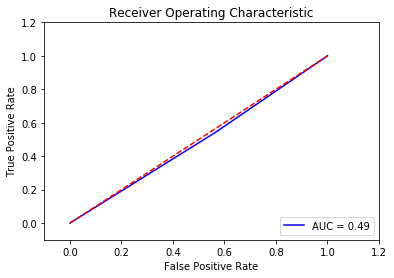

In [247]:
############################
#  DecisionTreeClassifier  #
############################
clf = tree.DecisionTreeClassifier()
y_pred = clf.fit(train_X, train_Y).predict(test_X)

fpr, tpr, thresholds = roc_curve(test_Y, y_pred)
model_auc = auc(fpr, tpr)
print('fpr:', fpr)
print('tpr:', tpr)
print('auc:', model_auc)
print(classification_report(test_Y, y_pred))
print('accuracy:', accuracy_score(test_Y, y_pred))
build_roc_curve(fpr, tpr, model_auc)

fpr: [0.         0.50328947 1.        ]
tpr: [0.         0.53299492 1.        ]
auc: 0.5148527250868288
             precision    recall  f1-score   support

      False       0.45      0.50      0.47       304
       True       0.58      0.53      0.55       394

avg / total       0.52      0.52      0.52       698

accuracy: 0.5171919770773639


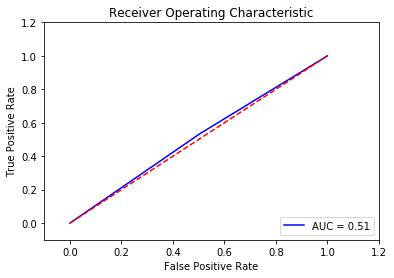

In [248]:
############################
#  RandomForestClassifier  #
############################
clf = ensemble.RandomForestClassifier()
y_pred = clf.fit(train_X, train_Y).predict(test_X)

fpr, tpr, thresholds = roc_curve(test_Y, y_pred)
model_auc = auc(fpr, tpr)
print('fpr:', fpr)
print('tpr:', tpr)
print('auc:', model_auc)
print(classification_report(test_Y, y_pred))
print('accuracy:', accuracy_score(test_Y, y_pred))
build_roc_curve(fpr, tpr, model_auc)

fpr: [0.         0.65131579 1.        ]
tpr: [0.         0.70558376 1.        ]
auc: 0.5271339834357468
             precision    recall  f1-score   support

      False       0.48      0.35      0.40       304
       True       0.58      0.71      0.64       394

avg / total       0.54      0.55      0.54       698

accuracy: 0.5501432664756447


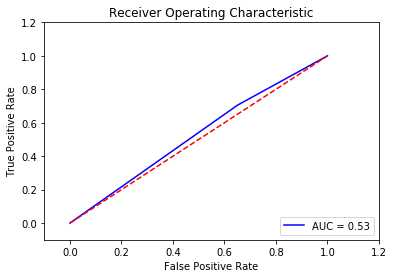

In [249]:
########################
#  AdaBoostClassifier  #
########################
clf = ensemble.AdaBoostClassifier()
y_pred = clf.fit(train_X, train_Y).predict(test_X)

fpr, tpr, thresholds = roc_curve(test_Y, y_pred)
model_auc = auc(fpr, tpr)
print('fpr:', fpr)
print('tpr:', tpr)
print('auc:', model_auc)
print(classification_report(test_Y, y_pred))
print('accuracy:', accuracy_score(test_Y, y_pred))
build_roc_curve(fpr, tpr, model_auc)

fpr: [0.         0.68421053 1.        ]
tpr: [0.        0.7106599 1.       ]
auc: 0.513224686080684
             precision    recall  f1-score   support

      False       0.46      0.32      0.37       304
       True       0.57      0.71      0.63       394

avg / total       0.52      0.54      0.52       698

accuracy: 0.5386819484240688


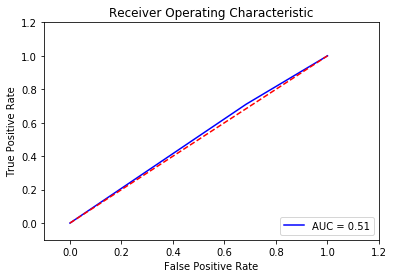

In [250]:
################################
#  GradientBoostingClassifier  #
################################
clf = ensemble.GradientBoostingClassifier()
y_pred = clf.fit(train_X, train_Y).predict(test_X)

fpr, tpr, thresholds = roc_curve(test_Y, y_pred)
model_auc = auc(fpr, tpr)
print('fpr:', fpr)
print('tpr:', tpr)
print('auc:', model_auc)
print(classification_report(test_Y, y_pred))
print('accuracy:', accuracy_score(test_Y, y_pred))
build_roc_curve(fpr, tpr, model_auc)